In [4]:
#install required libraries
!pip install findspark
!pip install pyspark

In [5]:
# Initialization. Libraries imported in alphabetical order.
from collections import Counter

import findspark
import matplotlib.pyplot as plt
import os
import pandas as pd

from pyspark.sql import SparkSession, functions as F
from pyspark.sql.functions import udf, monotonically_increasing_id
from pyspark.sql.types import IntegerType
from pyspark.ml import Pipeline
from pyspark.ml.classification import (
    LogisticRegression, RandomForestClassifier, GBTClassifier
)
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import (
    OneHotEncoder,
    StringIndexer,
    StandardScaler,
    VectorAssembler,
    IndexToString,
    VectorIndexer
)

import seaborn as sns
import time

# Configurations.
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.options.mode.chained_assignment = None

%matplotlib inline

# Constants.
START_TIME = time.time()

In [6]:
# Create a SparkSession and specify configuration.
spark = SparkSession\
    .builder.master("local")\
    .config("spark.driver.cores", 4)\
    .appName("intrusion-detection").getOrCreate()

spark

In [7]:
# Reading data files with all info and assigning correct colNames.
train_set = spark.read.option("inferSchema", "true").csv(
    "/content/KDDTrain+.txt"
)
test_set = spark.read.option("inferSchema", "true").csv("/content/KDDTest+.txt")

features = [
    "duration",
    "protocol_type",
    "service",
    "flag","src_bytes",
    "dst_bytes",
    "land",
    "wrong_fragment",
    "urgent",
    "hot",
    "num_failed_logins",
    "logged_in",
    "num_compromised",
    "root_shell",
    "su_attempted",
    "num_root",
    "num_file",
    "num_shells",
    "num_access_files",
    "num_outbound_cmds",
    "is_host_login",
    "is_guest_login",
    "count",
    "srv_count",
    "serror_rate",
    "srv_serror_rate",
    "rerror_rate",
    "srv_rerror_rate",
    "same_srv_rate",
    "diff_srv_rate",
    "srv_diff_host_rate",
    "dst_host_count",
    "dst_host_srv_count",
    "dst_host_same_srv_rate",
    "dst_host_diff_srv_rate",
    "dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate",
    "dst_host_serror_rate",
    "dst_host_srv_serror_rate",
    "dst_host_rerror_rate",
    "dst_host_srv_rerror_rate",
    "label",
    "times_correctly_classified"
]

rawnames = train_set.schema.names

def updateColNames(df, oldnames, newnames):
    """Definition to rename a spark 'dataframe' columns"""

    for i in range(len(newnames)):
        df = df.withColumnRenamed(oldnames[i], newnames[i])

    return df

train_set = updateColNames(train_set,rawnames,features)
test_set = updateColNames(test_set,rawnames,features)

test_set.printSchema()

root
 |-- duration: integer (nullable = true)
 |-- protocol_type: string (nullable = true)
 |-- service: string (nullable = true)
 |-- flag: string (nullable = true)
 |-- src_bytes: integer (nullable = true)
 |-- dst_bytes: integer (nullable = true)
 |-- land: integer (nullable = true)
 |-- wrong_fragment: integer (nullable = true)
 |-- urgent: integer (nullable = true)
 |-- hot: integer (nullable = true)
 |-- num_failed_logins: integer (nullable = true)
 |-- logged_in: integer (nullable = true)
 |-- num_compromised: integer (nullable = true)
 |-- root_shell: integer (nullable = true)
 |-- su_attempted: integer (nullable = true)
 |-- num_root: integer (nullable = true)
 |-- num_file: integer (nullable = true)
 |-- num_shells: integer (nullable = true)
 |-- num_access_files: integer (nullable = true)
 |-- num_outbound_cmds: integer (nullable = true)
 |-- is_host_login: integer (nullable = true)
 |-- is_guest_login: integer (nullable = true)
 |-- count: integer (nullable = true)
 |-- srv

In [8]:
# Get list of strings and numerical columns.
str_list = [item[0] for item in train_set.dtypes if item[1].startswith(
    'string'
)]
num_list = [item[0] for item in train_set.dtypes if item[1].startswith(
    ('int','double')
)]

In [9]:
print(
    f"Shape of the train dataset: {train_set.toPandas().shape}\n"
    f"Shape of the test dataset: {test_set.toPandas().shape}"
)

Shape of the train dataset: (125973, 43)
Shape of the test dataset: (22544, 43)


In [10]:
# Join datasets so that transformations and analysis is performed only
# once.
df = train_set.union(test_set)
print(f"Rows in the joined dataframe: {df.count()}")

Rows in the joined dataframe: 148517


In [11]:
# Describe all the variables.
df.toPandas().describe(include="all")

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label,times_correctly_classified
count,148517.000000,148517,148517,148517,1.485170e+05,1.485170e+05,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.0,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517,148517.000000
unique,NaN,3,70,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40,NaN
top,NaN,tcp,http,SF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,normal,NaN
freq,NaN,121569,48191,89820,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,77054,NaN
mean,276.779305,NaN,NaN,NaN,4.022795e+04,1.708885e+04,0.000215,0.020523,0.000202,0.189379,0.004323,0.402789,0.255062,0.001508,0.000976,0.273726,0.012073,0.000525,0.004013,0.0,0.000081,0.012308,83.336561,28.251937,0.256925,0.255337,0.137947,0.138487,0.672983,0.067761,0.097441,183.928042,119.462661,0.534521,0.084103,0.145932,0.030584,0.256122,0.251304,0.136220,0.136397,NaN,19.278480
std,2460.683131,NaN,NaN,NaN,5.409612e+06,3.703525e+06,0.014677,0.240069,0.019417,2.013160,0.072248,0.490461,22.231375,0.038807,0.042389,22.689023,0.517863,0.027701,0.095257,0.0,0.008988,0.110259,116.760741,75.369635,0.431918,0.432578,0.339387,0.341783,0.436544,0.194666,0.258886,98.528328,111.232318,0.448061,0.194102,0.308638,0.108975,0.428500,0.429719,0.322741,0.335282,NaN,2.739757
min,0.000000,NaN,NaN,NaN,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000
25%,0.000000,NaN,NaN,NaN,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,87.000000,11.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,18.000000
50%,0.000000,NaN,NaN,NaN,4.400000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,13.000000,7.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,255.000000,72.000000,0.600000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,20.000000
75%,0.000000,NaN,NaN,NaN,2.780000e+02,5.710000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,141.000000,17.000000,0.850000,0.910000,0.000000,0.000000,1.000000,0.060000,0.000000,255.000000,255.000000,1.000000,0.070000,0.050000,0.010000,0.600000,0.500000,0.000000,0

In [12]:
# We can see that the variable num_outbound_cmds is composed by only
# zeroes. We can delete it.
df = df.drop('num_outbound_cmds')
num_list.remove('num_outbound_cmds')

In [13]:
# The feature'su_attempted' should be a binary feature,
# but has 3 factors.
Counter(df.toPandas().su_attempted)

Counter({0: 148433, 1: 23, 2: 61})

In [14]:
# 'Replace the value 2.0 for 0.0.
df = df.replace(2.0, 0.0, 'su_attempted')

# There are no null values on the dataset.
df.toPandas().isnull().sum()

duration                       0
protocol_type                  0
service                        0
flag                           0
src_bytes                      0
dst_bytes                      0
land                           0
wrong_fragment                 0
urgent                         0
hot                            0
num_failed_logins              0
logged_in                      0
num_compromised                0
root_shell                     0
su_attempted                   0
num_root                       0
num_file                       0
num_shells                     0
num_access_files               0
is_host_login                  0
is_guest_login                 0
count                          0
srv_count                      0
serror_rate                    0
srv_serror_rate                0
rerror_rate                    0
srv_rerror_rate                0
same_srv_rate                  0
diff_srv_rate                  0
srv_diff_host_rate             0
dst_host_c

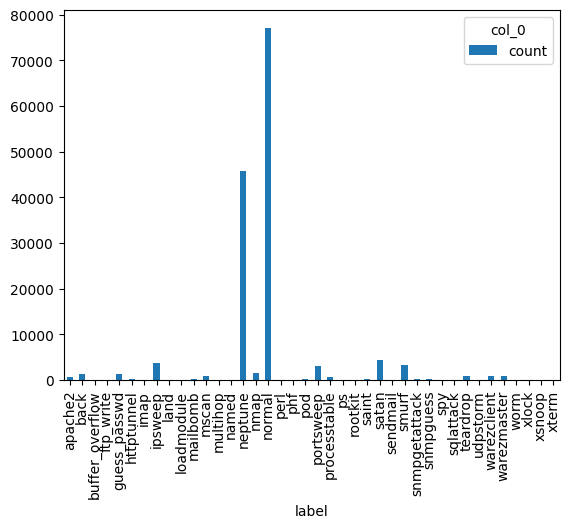

In [15]:
# Plot the frequency of the factors in the label variable.
my_tab = pd.crosstab(index=df.toPandas()["label"], columns="count")
my_tab.plot.bar();

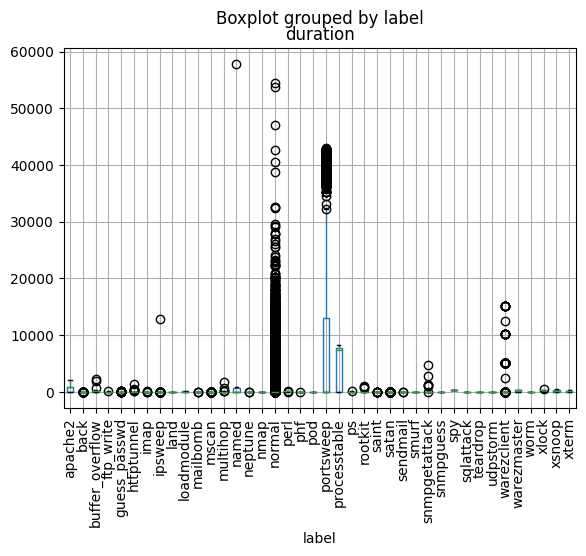

In [16]:
# Inspect the distribution of connection time in "duration" by type of
# connection.
ax = df.toPandas().boxplot(column="duration", by= "label")

for tick in ax.get_xticklabels():
    tick.set_rotation(90);

<ipython-input-17-a311292ef50a>:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.toPandas().corr(), annot=True, fmt=".1f");


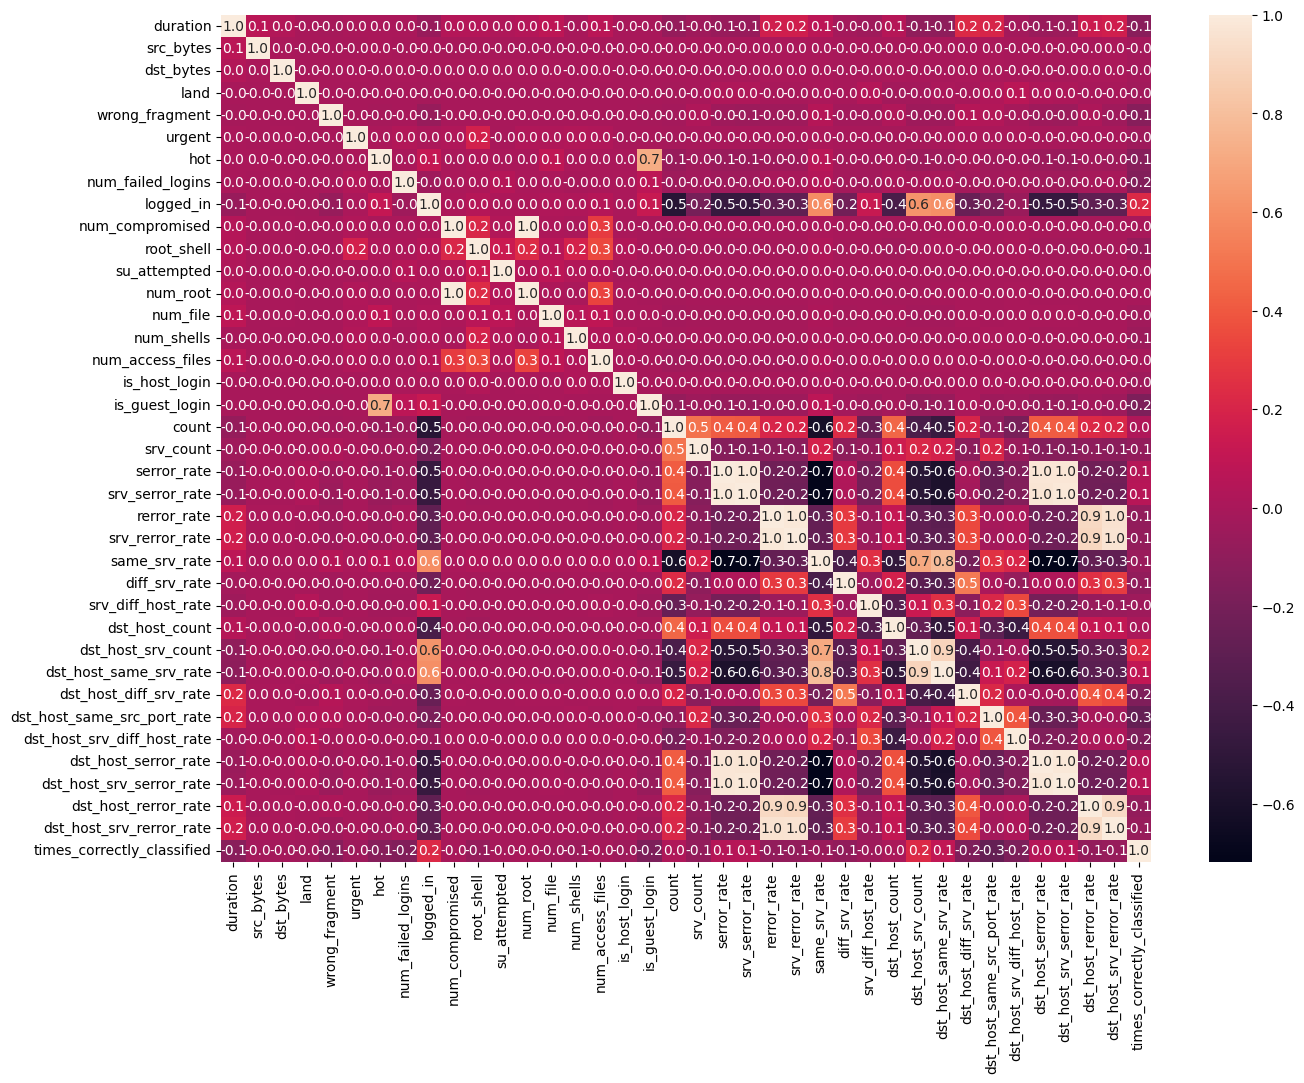

In [17]:
# Correlation heatmap.
fig, ax = plt.subplots()
fig.set_size_inches(15, 11)
sns.heatmap(df.toPandas().corr(), annot=True, fmt=".1f");

In [18]:
# Create a binary target variable. The connection will be either 'good'
# (0) or 'bad' (1).
binarize = lambda x: 1 if x != 'normal' else 0
udf_value_to_category = udf(binarize, IntegerType())
df = df.withColumn("label2", udf_value_to_category("label"))
pd.crosstab(index = df.toPandas()["label2"], columns="count")

col_0,count
label2,
0,77054
1,71463


In [19]:
categorical_columns = ["protocol_type", "service", "flag"]

# Stages in pipeline.
stages = []

for col in categorical_columns:
    # Category indexing with StringIndexer.
    indexer = StringIndexer(inputCol=col, outputCol=col+"_index")

    # Use OneHotEncoder to convert categorical variables into binary
    # SparseVectors.
    encoder = OneHotEncoder(inputCol=col+"_index", outputCol=col+"_vector")

    # Add stages. These are not run here, but will run all at once
    # later on.
    stages += [indexer, encoder]


# Transform all numerical features into a vector using VectorAssembler.
assembler_inputs = [
    col + "_vector" for col in categorical_columns
] + num_list

assembler = VectorAssembler(inputCols=assembler_inputs, outputCol="features")
stages += [assembler]

In [20]:
# List of the stages that the imported dataset will follow.
stages

[StringIndexer_4077ddfdc1cb,
 OneHotEncoder_b3b704e4b125,
 StringIndexer_0c71f1d3ed9a,
 OneHotEncoder_f8e6f97596ac,
 StringIndexer_7cb039afb706,
 OneHotEncoder_291d08b6273f,
 VectorAssembler_9a602c95cc56]

In [21]:
# Create a Pipeline.
pipeline = Pipeline(stages=stages)

# Run the feature transformations.
transformer = pipeline.fit(df)
transformed_df = transformer.transform(df)

selection = ["features", "label2"]
dataset = transformed_df.select(selection)

# Change column name.
dataset = dataset.selectExpr("features as features", "label2 as label")
dataset.show()

+--------------------+-----+
|            features|label|
+--------------------+-----+
|(119,[0,6,71,82,9...|    0|
|(119,[1,7,71,82,9...|    0|
|(119,[0,3,72,99,1...|    1|
|(119,[0,2,71,82,8...|    0|
|(119,[0,2,71,82,8...|    0|
|(119,[0,3,73,99,1...|    1|
|(119,[0,3,72,99,1...|    1|
|(119,[0,3,72,99,1...|    1|
|(119,[0,58,72,99,...|    1|
|(119,[0,3,72,99,1...|    1|
|(119,[0,3,73,99,1...|    1|
|(119,[0,3,72,99,1...|    1|
|(119,[0,2,71,82,8...|    0|
|(119,[0,6,71,82,8...|    1|
|(119,[0,40,72,99,...|    1|
|(119,[0,49,72,99,...|    1|
|(119,[0,2,71,82,8...|    0|
|(119,[8,71,82,99,...|    1|
|(119,[0,2,71,82,8...|    0|
|(119,[0,2,71,82,8...|    0|
+--------------------+-----+
only showing top 20 rows



In [22]:
# Split data again into train and test. First, add an index column:
dataset_i = dataset.withColumn('index', F.monotonically_increasing_id())

train_data = dataset.limit(train_set.count())
test_data = dataset_i.sort('index', ascending=False).limit(test_set.count())
test_data = test_data.drop('index')

print(
    f"Train dataset rows: {train_data.count()}\n"
    f"Test dataset rows: {test_data.count()}"
)

Train dataset rows: 125973
Test dataset rows: 22544


In [23]:
# Baseline model. Logistic regression.
lr = LogisticRegression(maxIter=100, regParam=0.3, labelCol = 'label')

# Fit the model
lr_model = lr.fit(train_data)

# Make predictions.
lr_predictions = lr_model.transform(test_data)
lr_predictions.select(
    'features', 'label', 'prediction', 'probability'
).show(10)

+--------------------+-----+----------+--------------------+
|            features|label|prediction|         probability|
+--------------------+-----+----------+--------------------+
|(119,[0,35,73,99,...|    1|       1.0|[0.12904429899745...|
|(119,[1,4,71,82,8...|    0|       0.0|[0.91778899872037...|
|(119,[0,2,71,82,8...|    1|       0.0|[0.84810493930955...|
|(119,[0,2,71,82,8...|    0|       0.0|[0.92423501029936...|
|(119,[0,5,71,82,8...|    0|       0.0|[0.91142109578591...|
|(119,[10,71,82,99...|    1|       0.0|[0.54699355073803...|
|(119,[0,5,71,81,8...|    1|       0.0|[0.74445932675892...|
|(119,[0,20,73,99,...|    1|       1.0|[0.19675762025565...|
|(119,[0,2,71,82,8...|    0|       0.0|[0.93085753703171...|
|(119,[0,3,73,99,1...|    1|       1.0|[0.15444322672957...|
+--------------------+-----+----------+--------------------+
only showing top 10 rows



In [24]:
# Evaluate predictions.
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(lr_predictions))

Test Area Under ROC 0.9477050517454634


In [27]:
# Random Forest.
rf = RandomForestClassifier(
    maxDepth=7,
    maxBins=64,
    maxMemoryInMB=512,
    numTrees=100,
    seed=123,
)
rf_model = rf.fit(train_data)

In [28]:
rf_predictions = rf_model.transform(test_data)
rf_predictions.show(10)

+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|(119,[0,35,73,99,...|    1|[28.5675522928961...|[0.28567552292896...|       1.0|
|(119,[1,4,71,82,8...|    0|[98.1780050380242...|[0.98178005038024...|       0.0|
|(119,[0,2,71,82,8...|    1|[16.8374727019130...|[0.16837472701913...|       1.0|
|(119,[0,2,71,82,8...|    0|[99.0715327408140...|[0.99071532740814...|       0.0|
|(119,[0,5,71,82,8...|    0|[98.4665492271994...|[0.98466549227199...|       0.0|
|(119,[10,71,82,99...|    1|[31.0052877178876...|[0.31005287717887...|       1.0|
|(119,[0,5,71,81,8...|    1|[76.0120253276665...|[0.76012025327666...|       0.0|
|(119,[0,20,73,99,...|    1|[0.48917842502457...|[0.00489178425024...|       1.0|
|(119,[0,2,71,82,8...|    0|[99.0290687626575...|[0.99029068762657...|       0.0|
|(119,[0,3,73,99

In [29]:
print(
    "Test Area Under ROC: " + str(
        evaluator.evaluate(
            rf_predictions, {evaluator.metricName: "areaUnderROC"}
        )
    )
)

Test Area Under ROC: 0.9731518649429832


In [30]:
# Gradient-Boosted Tree Classifier.
gbt = GBTClassifier(maxIter=100)
gbt_model = gbt.fit(train_data)

gbt_predictions = gbt_model.transform(test_data)
gbt_predictions.show(10)

+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|(119,[0,35,73,99,...|    1|[-1.2279105578593...|[0.07901390303998...|       1.0|
|(119,[1,4,71,82,8...|    0|[2.23414817083462...|[0.98866316285100...|       0.0|
|(119,[0,2,71,82,8...|    1|[-1.4705590715204...|[0.05015797564584...|       1.0|
|(119,[0,2,71,82,8...|    0|[2.23414817083462...|[0.98866316285100...|       0.0|
|(119,[0,5,71,82,8...|    0|[2.23414817083462...|[0.98866316285100...|       0.0|
|(119,[10,71,82,99...|    1|[-2.2218399428711...|[0.01161609118736...|       1.0|
|(119,[0,5,71,81,8...|    1|[-1.1471107531928...|[0.09160266541343...|       1.0|
|(119,[0,20,73,99,...|    1|[-2.2123196479830...|[0.01183674441360...|       1.0|
|(119,[0,2,71,82,8...|    0|[2.23414817083462...|[0.98866316285100...|       0.0|
|(119,[0,3,73,99

In [31]:
print(
    "Test Area Under ROC: " + str(
        evaluator.evaluate(
            gbt_predictions, {evaluator.metricName: "areaUnderROC"}
        )
    )
)

Test Area Under ROC: 0.9203722602297814


In [32]:
# The model with the best results was the Random Forest classifier.
rf_model_final = rf.fit(train_data)
final_predictions = rf_model_final.transform(test_data)

# Save output into a csv.
final_predictions.toPandas()[
    ['probability', 'prediction']
].to_csv('test_predictions.csv', index=True)

# Close Spark context.
spark.stop()


print(f"Runtime in minutes -> {((time.time() - START_TIME) / 60)}")

Runtime in minutes -> 11.03924834728241
